# CrabNet Bandgap Prediction for Chalcogenide Perovskites

This notebook implements the **composition-based bandgap prediction** described in
Section 3.3 of the manuscript. We use [CrabNet v2](https://doi.org/10.1038/s41524-021-00545-1)
(Compositionally-Restricted Attention-Based Network) with **Pettifor composition
fingerprints** as extended features.

**Training data** — three sources, merged and deduplicated:

| Source | Description | Approx. entries |
|--------|-------------|----------------:|
| Halide perovskites | NOMAD bandgap records (ABX₃, X = halide) | ~51 000 |
| Chalcogenide perovskites | Experimentally reported (ABX₃, X = S, Se) | 17 |
| Chalcogenide semiconductors | Literature with Chem Data Extractor (non-perovskite chalcogenides) | ~17 800 |

**Key analysis additions**:
- Leave-One-Out Cross-Validation (LOOCV) on the 11 unique chalcogenide perovskite
  formulas to obtain per-compound error estimates.
- Publication-quality parity plot with color coding by data source.
- Ablation studies for data-source contribution and Pettifor features.
- Null-model baselines (median / mean predictor).

---
## 0. Setup

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- Patch SWA for PyTorch >= 2.x compatibility ---
# CrabNet v2.0.8 bundles its own SWA (crabnet.utils.optim.SWA) which lacks
# attributes expected by modern PyTorch optimizers.
from crabnet.utils.optim import SWA  # type: ignore
if not getattr(SWA, '_patched', False):
    _original_swa_init = SWA.__init__
    def _patched_swa_init(self, *args, **kwargs):
        _original_swa_init(self, *args, **kwargs)
        if not hasattr(self, '_optimizer_step_pre_hooks'):
            self._optimizer_step_pre_hooks = {}
        if not hasattr(self, '_optimizer_step_post_hooks'):
            self._optimizer_step_post_hooks = {}
    SWA.__init__ = _patched_swa_init
    SWA._patched = True
# ------------------------------------------------

from crabnet.crabnet_ import CrabNet          # type: ignore
from crabnet.utils.data import groupby_formula # type: ignore

from tf_chpvk_pv.config import (
    RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR,
    TRAINED_MODELS, FIGURES_DIR,
)
from tf_chpvk_pv.modeling.CrabNet.utils import (
    DEVICE,
    get_raw_data,
    save_processed_data,
    get_petiffor_features,
    load_model,
    test_r2_score,
    predict_bandgap,
    get_CrystaLLM_predictions,
    get_SISSO_predictions,
    get_experimental_predictions,
)

RANDOM_SEED = 42
print(f'Device: {DEVICE}')

# Matplotlib defaults for publication figures
mpl.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

2026-02-18 14:54:32.566 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV


2026-02-18 14:54:32.582 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:<module>:20 - CrabNet device: mps
Device: mps


---
## 1. Data Loading & Preprocessing

We load three CSV sources, tag each row with its origin, and apply the following
filters:
1. Drop rows with missing bandgap or formula.
2. Keep only entries with bandgap > 1.0 eV.
3. Remove outliers: entries whose bandgap deviates more than 0.3 eV from the
   median of their formula group.

> **Note:** Outlier removal is applied on the full dataset before splitting, which
> could introduce a minor information leak. This is a deliberate preprocessing
> choice — the medians used for filtering are per-formula statistics that barely
> change when a single entry is held out.

In [2]:
from tf_chpvk_pv.dataset import get_perovskite_data_NOMAD

# Ensure the NOMAD data file exists locally
get_perovskite_data_NOMAD(False)

# Load & clean
df = get_raw_data()
print(f'Cleaned dataset: {df.shape[0]} rows, {df["reduced_formulas"].nunique()} unique formulas')
df.head(3)

Importing existing data... with size: (51123, 3)
The data comes from the following sources:
74.16 % from halide perovskites,
0.0232 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
Cleaned dataset: 50660 rows, 3627 unique formulas


,reduced_formulas,descriptive_formulas,bandgap,source
0,CH6I3NPb,MAPbI3,1.6,pvk
2,CH6I3NPb,MAPbI3,1.5,pvk
3,CH6I3NPb,MAPbI3,1.6,pvk


---
## 2. Formula Grouping & Deduplication

Many formulas appear multiple times with different reported bandgap values.
We group by formula and take the **median** bandgap to obtain one target per
unique composition. The `source` column is preserved on the original DataFrame
for later use in stratified splitting and LOOCV.

In [3]:
# Rename to CrabNet convention
df.rename(columns={'bandgap': 'target', 'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas — median target
df_grouped = groupby_formula(df, how='median')

# Attach source information to the grouped frame
for formula in df_grouped['formula']:
    df_grouped.loc[df_grouped['formula'] == formula, 'source'] = (
        df.loc[df['formula'] == formula, 'source'].values[0]
    )

# Source breakdown
src_pct = (df_grouped['source'].value_counts() / len(df_grouped) * 100)
print(f'Unique compositions: {len(df_grouped)}')
for src, pct in src_pct.items():
    print(f'  {src:20s}: {pct:6.2f}%')

save_processed_data(df_grouped)

Unique compositions: 3627
  chalc_semicon       :  56.19%
  pvk                 :  43.53%
  chalcogenides       :   0.28%
2026-02-18 14:54:37.553 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:save_processed_data:93 - Processed data saved to /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV/data/interim/df_grouped_formula_complete_dataset.csv


---
## 3. Feature Engineering — Pettifor Composition Embedding

We compute a 98-dimensional Pettifor fingerprint for each formula using a
composition-weighted embedding matrix. The data is then split
**80 / 10 / 10** (train / validation / test) with **stratification by source**
to maintain the class balance across splits.

In [4]:
# Drop source before splitting (get_petiffor_features re-adds it internally for stratification)
df_grouped_no_src = df_grouped.drop(columns=['source'])

train_df, val_df, test_df, feature_names = get_petiffor_features(
    df_grouped_no_src, original_df=df, train=True
)

print(f'Train: {len(train_df):>5d}  |  Val: {len(val_df):>5d}  |  Test: {len(test_df):>5d}')
print(f'Pettifor feature columns: {len(feature_names)}')

Train:  2901  |  Val:   363  |  Test:   363
Pettifor feature columns: 98


### Element Prevalence

Visual check of elemental coverage in the training set using
[pymatviz](https://pymatviz.janosh.dev/).

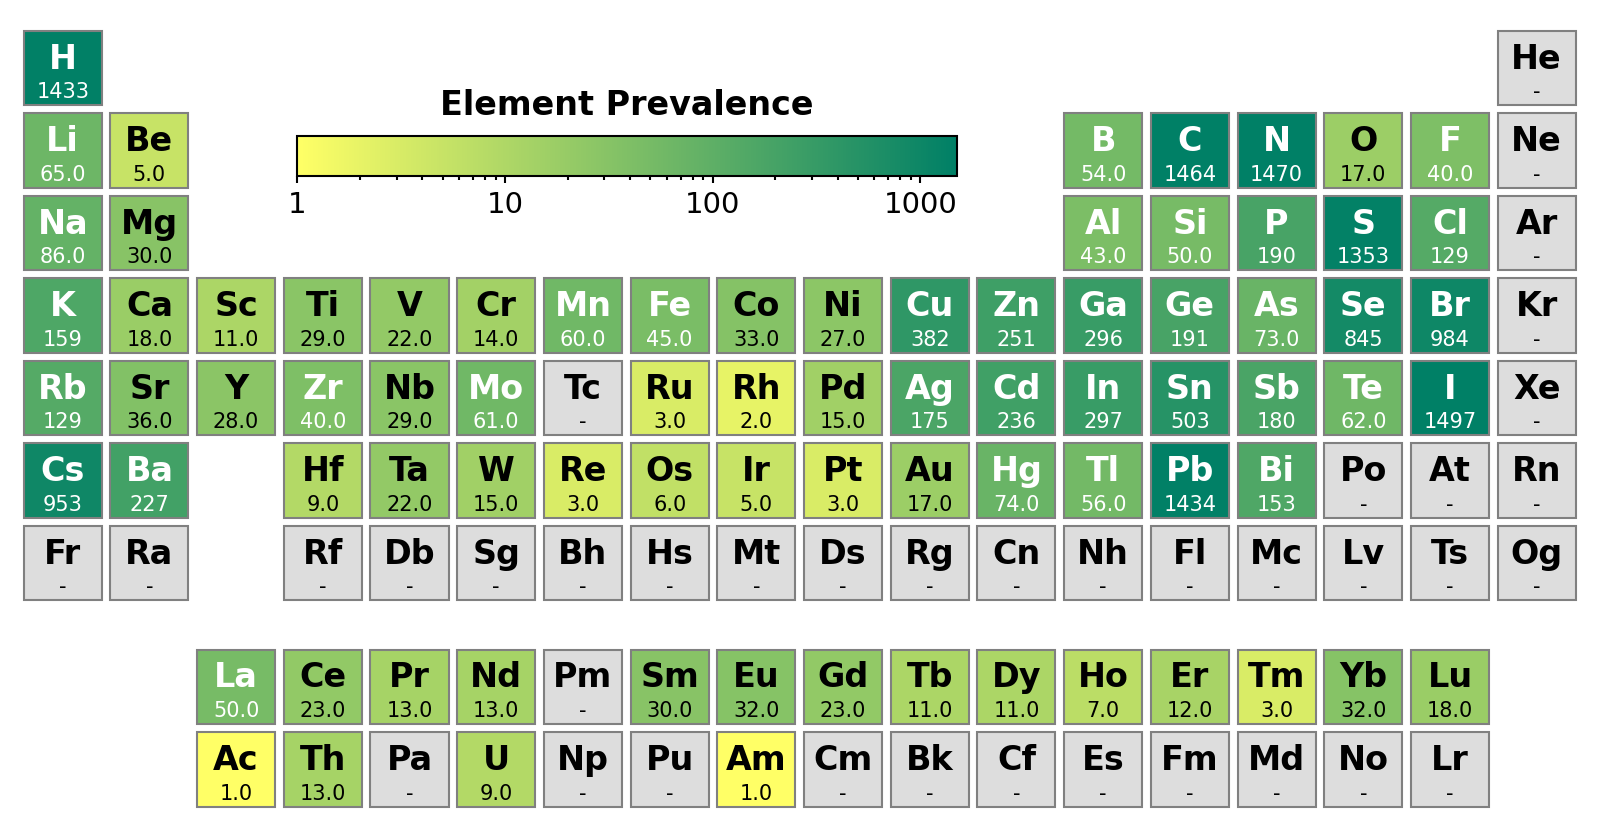

In [5]:
import re
from pymatviz import count_elements, ptable_heatmap  # type: ignore

element_counts = count_elements(
    [re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped['formula']]
)
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')
plt.show()

---
## 10b. Dataset Size Influence

To assess how the amount of training data affects model performance, we
train CrabNet on progressively larger random subsets of the full training
set (10 %, 20 %, 40 %, 60 %, 80 %, 100 %) and evaluate each model on the
**same held-out test set** as well as on the **chalcogenide perovskite
compounds** (direct evaluation, not LOOCV). We repeat each fraction 3
times with different random seeds to estimate variance.

This analysis directly quantifies the marginal value of additional data
and reveals whether the model is in a data-limited regime for the target
domain.


--- fraction=10%  seed=42 ---

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 290/290 [00:00<00:00, 316263.17formulae/s]


skipping composition OrderedDict([('H', 6.0), ('I', 3.0), ('P', 2.0), ('C', 1.0), ('N', 1.0), ('Pb', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 293981.92formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 8 elements in the formula
stepping every 30 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.461 val mae: 0.47


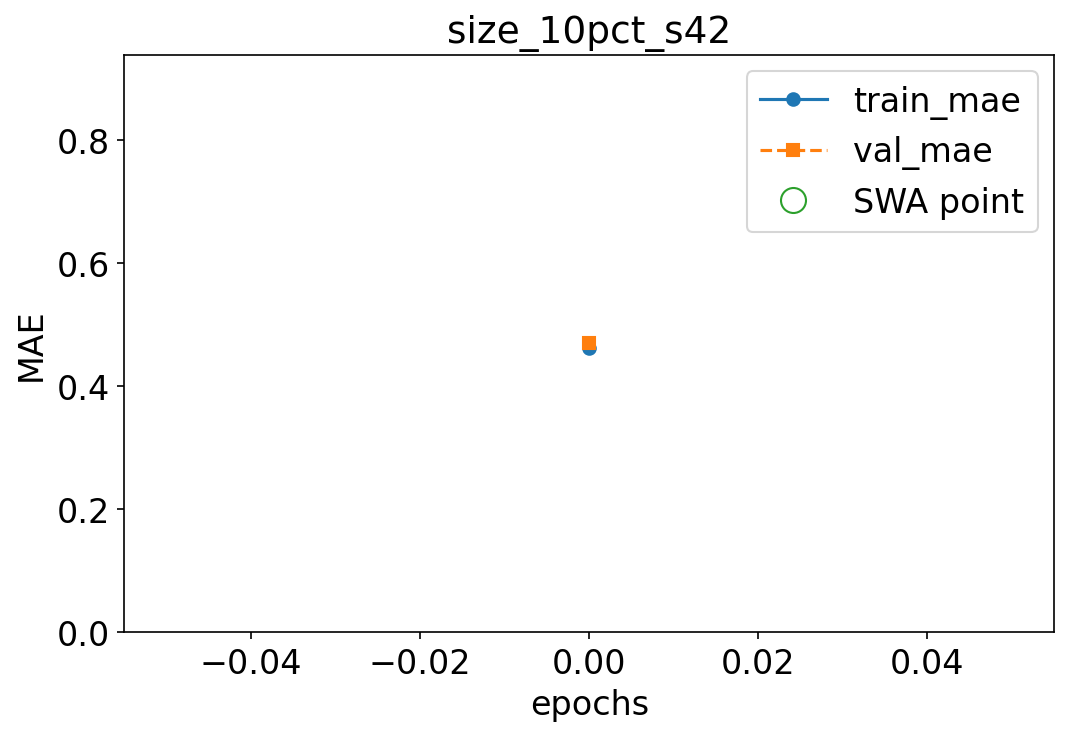

Epoch: 19/300 --- train mae: 0.32 val mae: 0.372


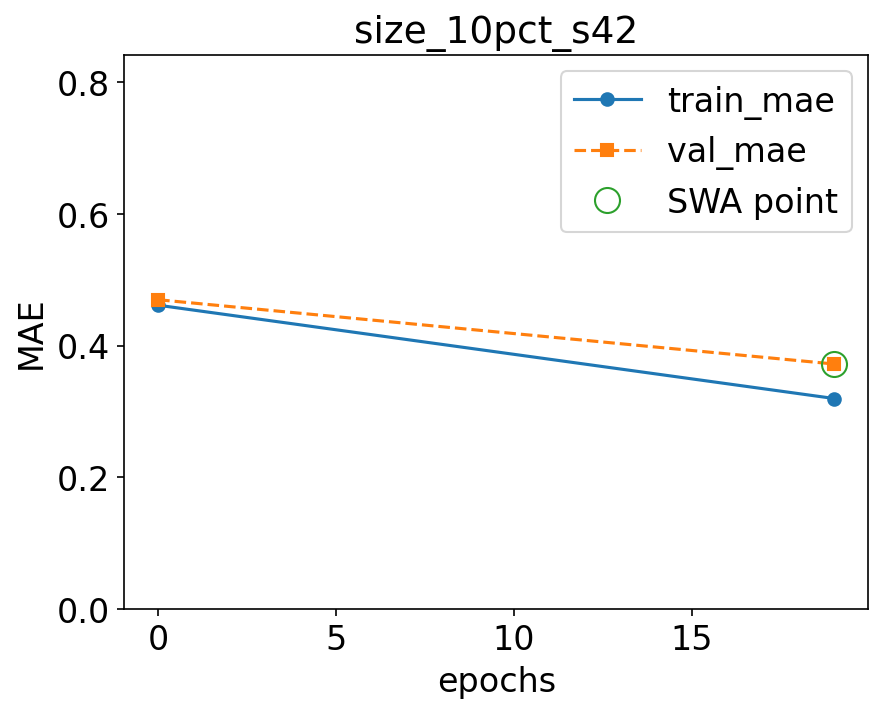

Epoch: 39/300 --- train mae: 0.274 val mae: 0.371


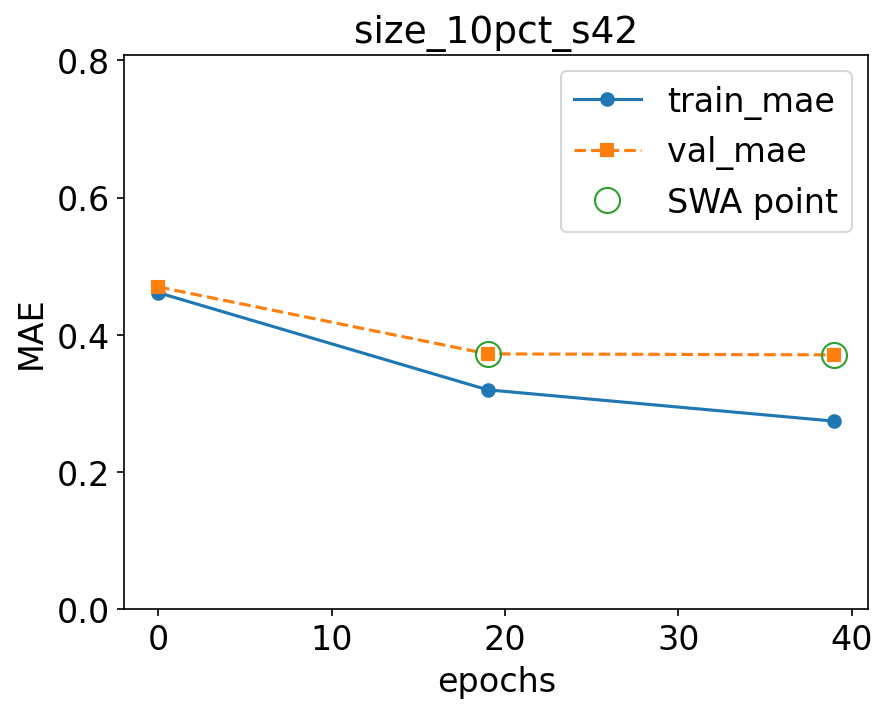

Epoch: 59/300 --- train mae: 0.197 val mae: 0.364


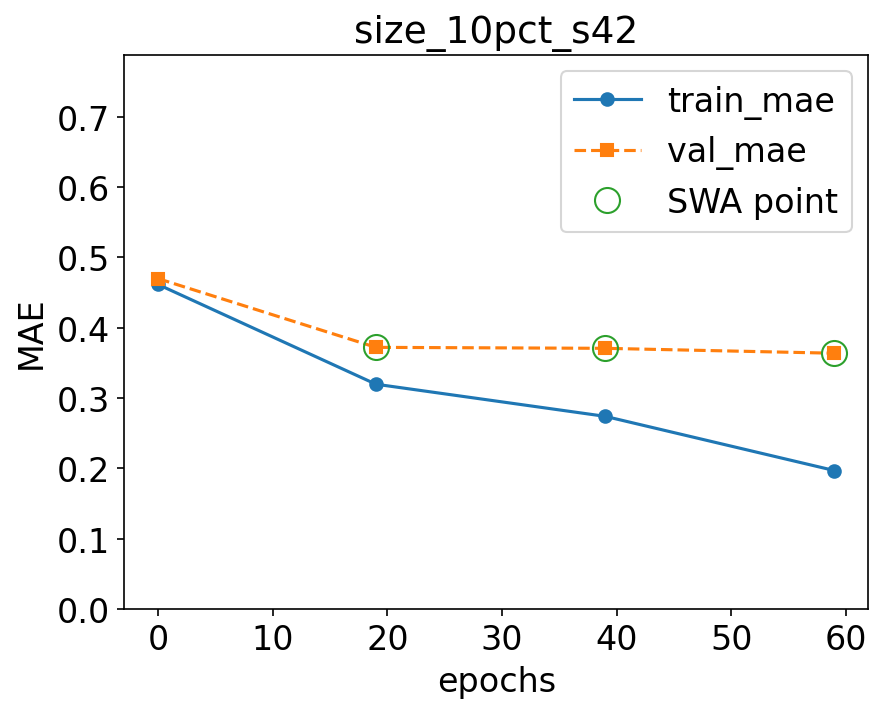

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.133 val mae: 0.368


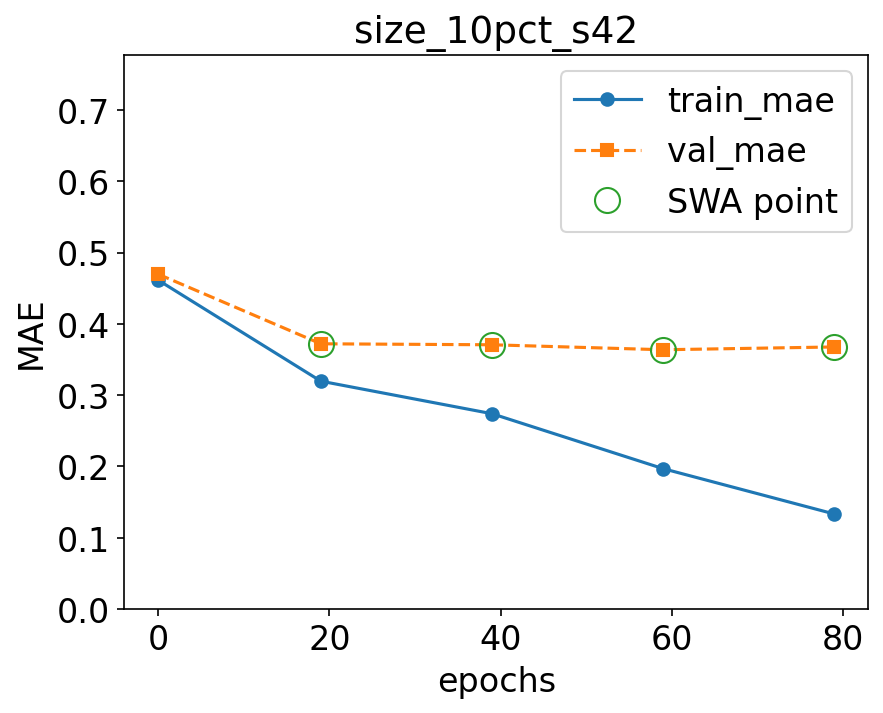

Epoch: 99/300 --- train mae: 0.103 val mae: 0.359


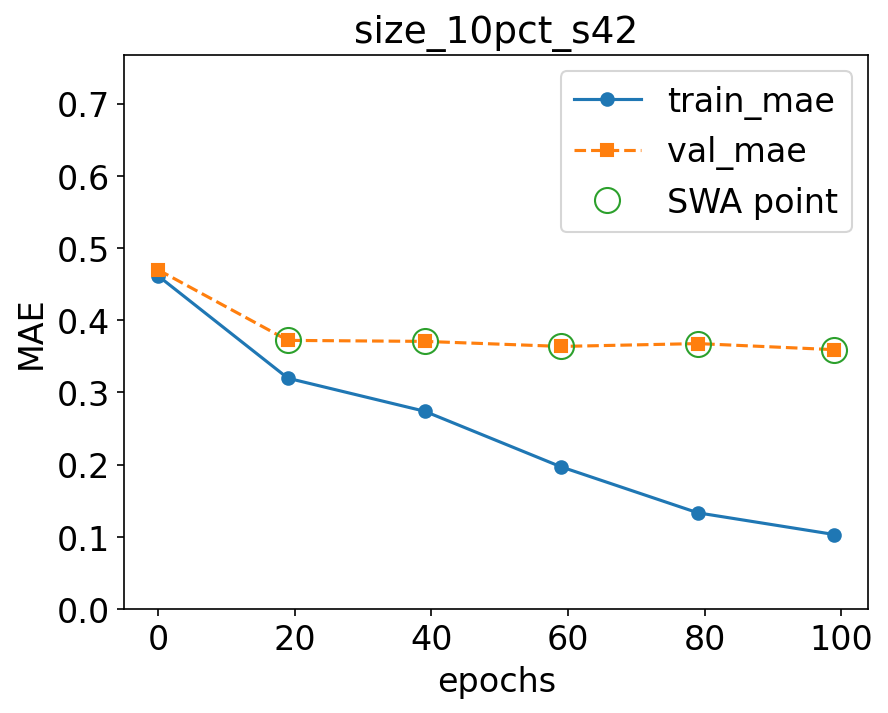

KeyboardInterrupt: 

In [ ]:
# --- Dataset size influence experiment ---
fractions = [0.10, 0.20, 0.40, 0.60, 0.80, 1.00]
n_repeats = 3
seeds = [42, 123, 7]

# Prepare chalcogenide perovskite evaluation set (same as ablation §9)
df_chalc_all = df_grouped[df_grouped['source'] == 'chalcogenides'].copy()
df_chalc_all = df_chalc_all[~df_chalc_all['formula'].isin(['BaTiS3', 'CaZrS3'])]
df_chalc_all_no_src = df_chalc_all.drop(columns=['source'])
df_chalc_eval = get_petiffor_features(df_chalc_all_no_src, original_df=df, train=False)

size_rows = []

for frac in fractions:
    for seed_idx, seed in enumerate(seeds):
        print(f'\n--- fraction={frac:.0%}  seed={seed} ---')

        if frac < 1.0:
            train_sub = train_df.sample(frac=frac, random_state=seed)
        else:
            train_sub = train_df.copy()

        model_sz = CrabNet(
            mat_prop='bandgap',
            model_name=f'size_{int(frac*100)}pct_s{seed}',
            elem_prop='mat2vec',
            learningcurve=False,
            extend_features=feature_names,
        )
        model_sz.fit(train_sub, val_df)

        # Evaluate on held-out test set
        m_test = test_r2_score(test_df, feature_names, crabnet_bandgap=model_sz, plot=False)

        # Evaluate on chalcogenide perovskites
        m_chalc = test_r2_score(df_chalc_eval, feature_names, crabnet_bandgap=model_sz, plot=False)

        size_rows.append({
            'fraction': frac,
            'n_train': len(train_sub),
            'seed': seed,
            'test_MAE': m_test['mae'],
            'test_R2': m_test['r2'],
            'chalc_MAE': m_chalc['mae'],
            'chalc_R2': m_chalc['r2'],
        })

size_df = pd.DataFrame(size_rows)

# Aggregate mean ± std over seeds
size_agg = size_df.groupby('fraction').agg(
    n_train=('n_train', 'first'),
    test_MAE_mean=('test_MAE', 'mean'),
    test_MAE_std=('test_MAE', 'std'),
    test_R2_mean=('test_R2', 'mean'),
    test_R2_std=('test_R2', 'std'),
    chalc_MAE_mean=('chalc_MAE', 'mean'),
    chalc_MAE_std=('chalc_MAE', 'std'),
    chalc_R2_mean=('chalc_R2', 'mean'),
    chalc_R2_std=('chalc_R2', 'std'),
).reset_index()

size_agg.style.format({
    'test_MAE_mean': '{:.3f}', 'test_MAE_std': '{:.3f}',
    'test_R2_mean': '{:.3f}',  'test_R2_std': '{:.3f}',
    'chalc_MAE_mean': '{:.3f}','chalc_MAE_std': '{:.3f}',
    'chalc_R2_mean': '{:.3f}', 'chalc_R2_std': '{:.3f}',
})

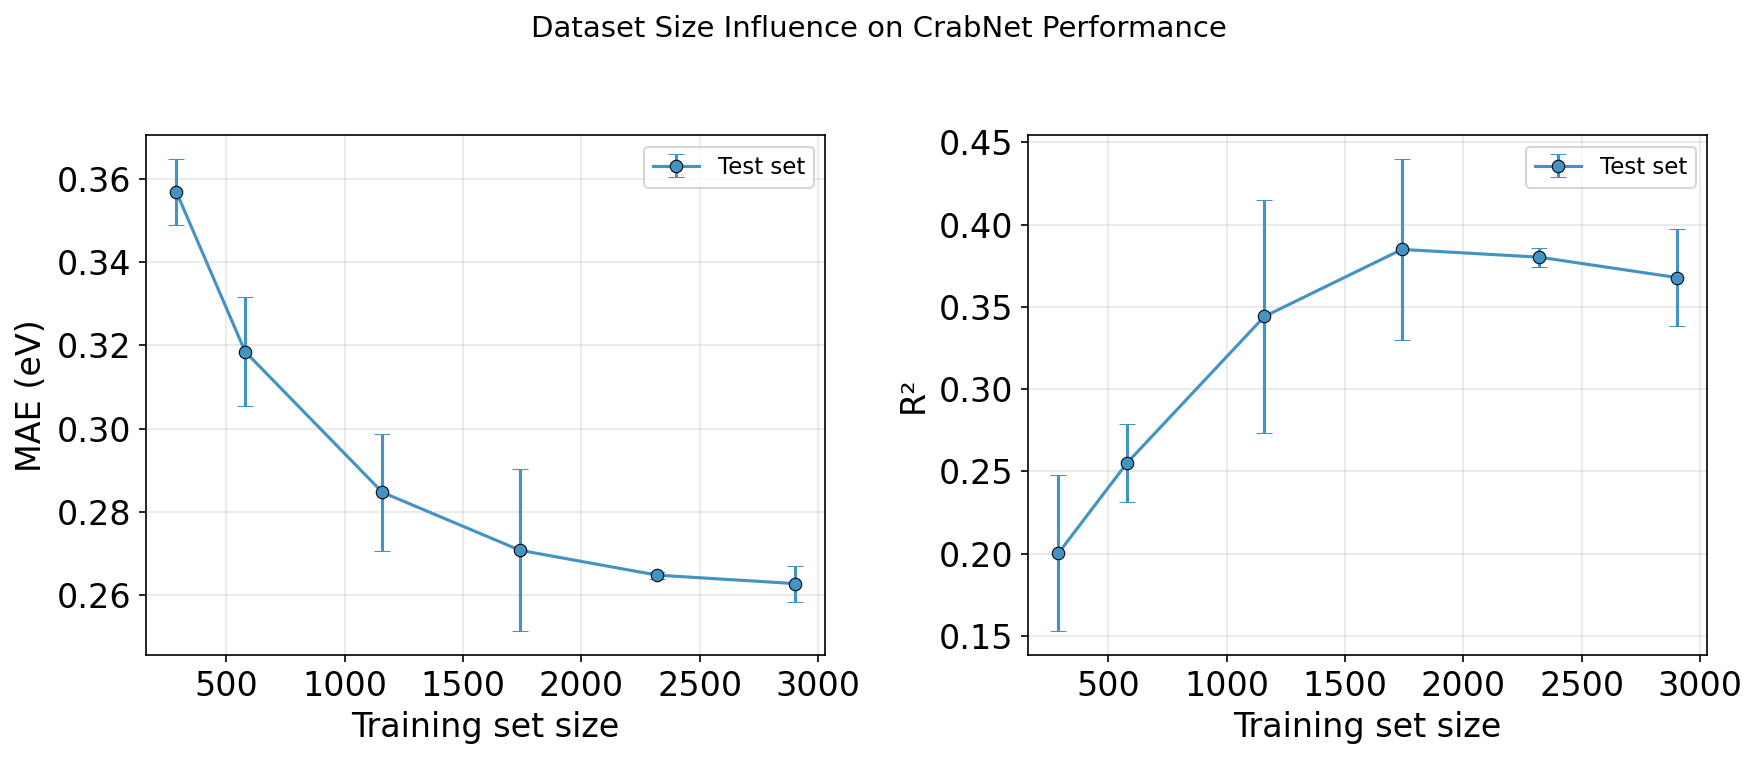

Saved to /Users/pepemarquez/git/Pepe-Marquez/TF-ChPVK-PV/reports/figures/dataset_size_influence.pdf


In [11]:
# --- Dataset size influence plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for ax, (metric, label) in zip(axes, [('MAE', 'MAE (eV)'), ('R2', 'R²')]):
    for subset, color, marker, lbl in [
        ('test', '#4393c3', 'o', 'Test set'),
        # ('chalc', '#d6604d', 's', 'Chalcogenide perovskites'),
    ]:
        col_mean = f'{subset}_{metric}_mean'
        col_std  = f'{subset}_{metric}_std'
        ax.errorbar(
            size_agg['n_train'], size_agg[col_mean],
            yerr=size_agg[col_std],
            fmt=f'-{marker}', color=color, capsize=4, markeredgecolor='k',
            markeredgewidth=0.5, label=lbl,
        )
    ax.set_xlabel('Training set size')
    ax.set_ylabel(label)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

fig.suptitle('Dataset Size Influence on CrabNet Performance', fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(FIGURES_DIR / 'dataset_size_influence.pdf')
fig.savefig(FIGURES_DIR / 'dataset_size_influence.png')
plt.show()
print(f'Saved to {FIGURES_DIR / "dataset_size_influence.pdf"}')